In [1]:
CUDA_INDEX = 5
NAME = 'Cora_ML'

In [2]:
import sys
sys.path.insert(0, '../..')
sys.path.insert(0, '../../pyged/lib')

In [3]:
import os
import pickle
import random
import time

import IPython as ipy
import matplotlib.pyplot as plt
import numpy as np
import torch
torch.cuda.set_device(CUDA_INDEX)
torch.backends.cudnn.benchmark = True
import torch.optim
import torch_geometric as tg
import torch_geometric.data
from tqdm.auto import tqdm

from neuro import config, datasets, metrics, models, train, utils, viz
import pyged

from importlib import reload
reload(config)
reload(datasets)
reload(metrics)
reload(models)
reload(pyged)
reload(train)
reload(utils)
reload(viz)

<module 'neuro.viz' from '../../neuro/viz.py'>

In [5]:
preds = [
    ('NeuroGSim     ', torch.load(f'../preds/{NAME}/outer_pred.pt', map_location='cpu')),
#     ('NeuroGSim-NN  ', torch.load(f'../preds/{NAME}/nn_outer_pred.pt', map_location='cpu')),
#     ('NeuroGSim-Dual', torch.load(f'../preds/{NAME}/dual_outer_pred.pt', map_location='cpu')),
#     ('NeuroMatch    ', torch.as_tensor(np.load(f'../preds/{NAME}/nm_outer_pred.npy'))),
    ('H2MN-RW        ', torch.as_tensor(np.load(f'../preds/{NAME}/h2mn_rw_outer.npy'))),
    ('H2MN-NE        ', torch.as_tensor(np.load(f'../preds/{NAME}/h2mn_ne_outer.npy'))),
    ('SimGNN        ', torch.as_tensor(np.load(f'../preds/{NAME}/sg_outer_pred.npy'))),
    ('Branch        ', torch.load(f'../preds/{NAME}/b_outer_pred.pt', map_location='cpu')),
    ('F2            ', torch.load(f'../preds/{NAME}/f2_outer_pred.pt', map_location='cpu')),
]

In [6]:
outer_test_set = torch.load(f'/data/rishabh/neurosim/final/data/{NAME}/outer_test.pt', map_location='cpu')
queries, _, lb, ub = outer_test_set

In [6]:
for label, pred in preds:
    Y = metrics.auroc_at_range(torch.tensor([1]), lb, ub, pred)
    Z = utils.nanmean(Y, dim=-1)
    print(f'{Z.item()*100:.2f}')

98.38
98.50
98.16
95.65
93.55


In [7]:
from scipy.stats import kendalltau
sed = (lb+ub)/2
for i, (label, pred) in enumerate(preds):
    tmp = []
    for i in range(len(queries)):
        tmp.append(kendalltau(sed[i], pred[i], nan_policy='omit')[0])
    tau = sum(tmp)/len(tmp)
    print(f'{tau:.3f}')

0.906
0.879
0.869
0.858
0.754
0.712


In [6]:
for label, pred in preds:
    Y = metrics.auroc_at_range(torch.tensor([1]), lb, ub, pred)
    Z = utils.nanmean(Y, dim=-1)
    print(f'{Z.item()*100:.2f}')

99.28
99.42
99.00
94.98
98.80
96.99
94.59


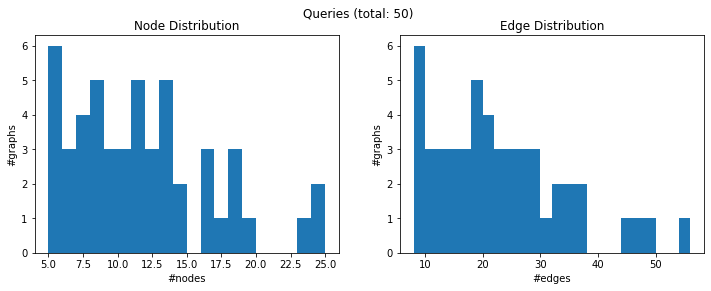

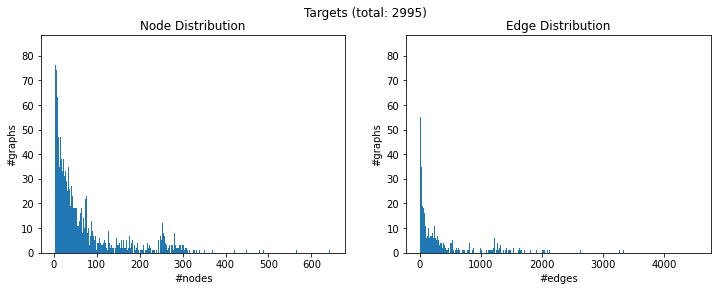

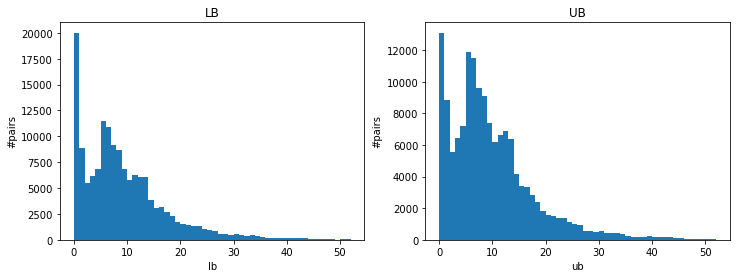

In [6]:
viz.plot_dataset_dist(outer_test_set)

In [8]:
def rank_metrics(fn, lb, ub, preds, ylabel, title, percent=True):
    k = torch.arange(1, 21, 1)
    plt.figure()
    Ys = []
    for label, pred in preds:
        Y = fn(k, lb, ub, pred)
        viz.plot_summary(k, Y, show_std=False, label=label, lim=percent)
        Ys.append((Y, label))
    plt.legend()
    plt.xlabel('k')
    plt.ylabel(ylabel)
    plt.title(title)
    plt.show()
    
    for Y, label in Ys:
#         print(f'{label}', end='\n')
        Z = torch.mean(Y, dim=-1)
        for i in [1,5,10,15,20]:
            if percent:
                print(f'{Z[i-1].item()*100:.2f}', end=' / ' if i != 20 else '\n')
            else:
                print(f'{Z[i-1].item():.3f}', end=' / ' if i != 20 else '\n')
#         print()

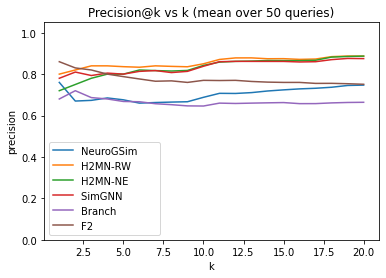

76.00 / 67.60 / 68.80 / 72.40 / 74.70
80.00 / 83.60 / 85.00 / 87.47 / 88.70
72.00 / 80.00 / 84.20 / 86.53 / 88.70
78.00 / 80.00 / 83.80 / 86.13 / 87.50
68.00 / 66.80 / 64.60 / 66.27 / 66.40
86.00 / 78.80 / 77.00 / 76.00 / 75.10


In [9]:
rank_metrics(metrics.precision_at_k, (lb+ub)/2, (lb+ub)/2, preds,
            'precision', f'Precision@k vs k (mean over {len(queries)} queries)')

In [9]:
for label, pred in preds:
#     print(f'{label}', end='\n')
    tmp = torch.mean(metrics.kendalls_tau_at_k(torch.tensor([20]), lb[:5], ub[:5], pred[:5])).item()
    print(f'{tmp*100:.2f}')
#     print()

96.42
91.79
91.58
78.32
90.74


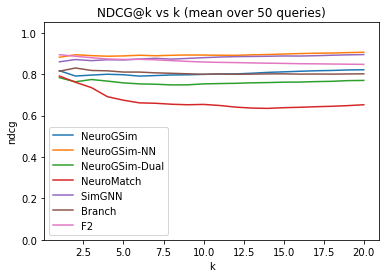

81.65 / 79.70 / 79.90 / 81.10 / 82.11
88.15 / 88.80 / 89.20 / 89.70 / 90.57
78.28 / 75.77 / 75.29 / 76.12 / 76.97
79.08 / 67.40 / 65.37 / 63.79 / 65.21
85.94 / 86.85 / 87.95 / 88.77 / 89.44
81.40 / 81.00 / 79.90 / 80.14 / 80.15
89.38 / 87.09 / 85.84 / 85.18 / 84.71


In [14]:
rank_metrics(metrics.ndcg_at_k, lb, ub, preds,
            'ndcg', f'NDCG@k vs k (mean over {len(queries)} queries)')

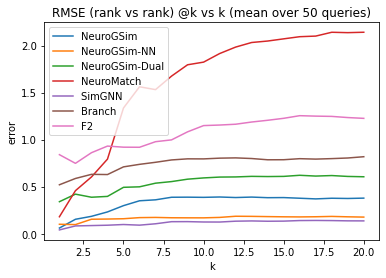

0.060 / 0.298 / 0.386 / 0.384 / 0.378
0.100 / 0.159 / 0.168 / 0.179 / 0.176
0.340 / 0.493 / 0.593 / 0.609 / 0.605
0.180 / 1.336 / 1.824 / 2.071 / 2.142
0.040 / 0.097 / 0.124 / 0.133 / 0.136
0.520 / 0.710 / 0.795 / 0.786 / 0.818
0.840 / 0.920 / 1.149 / 1.227 / 1.226


In [15]:
rank_metrics(metrics.rmse_at_k, lb, ub, preds,
            'error', f'RMSE (rank vs rank) @k vs k (mean over {len(queries)} queries)',
            percent=False)

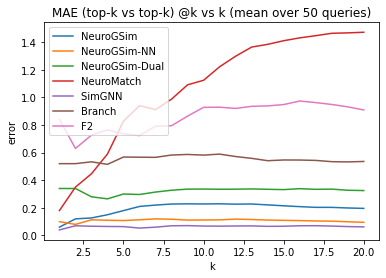

0.060 / 0.180 / 0.228 / 0.215 / 0.196
0.100 / 0.108 / 0.112 / 0.109 / 0.095
0.340 / 0.300 / 0.336 / 0.332 / 0.325
0.180 / 0.828 / 1.124 / 1.411 / 1.472
0.040 / 0.064 / 0.068 / 0.067 / 0.062
0.520 / 0.568 / 0.582 / 0.547 / 0.536
0.840 / 0.736 / 0.928 / 0.948 / 0.909


In [17]:
rank_metrics(metrics.error_at_k, lb, ub, preds,
            'error', f'MAE (top-k vs top-k) @k vs k (mean over {len(queries)} queries)',
            percent=False)